In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import plotly.express as px
from random import sample
import sklearn.cluster
from sklearn.cluster import KMeans
import sklearn.manifold
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
import json
import os

main_dir = os.path.dirname(os.getcwd())
pyktok_dir = f'{main_dir}/pyktok-results'

In [82]:

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def getsuggested_wordsfromcsv(filename):
    sugg_words = []
    file = f'{pyktok_dir}/{filename}'
    print(f'Getting pyktok data from file {file}')
    metadata = pd.read_csv(file)
    for index, row in metadata.iterrows():
        if row['suggested_words']:
            sugg_words += str(row['suggested_words']).split(',')
    return sugg_words

def getsuggested_wordsfromjson(filename):
    sugg_words = []
    file = f'{filename}'
    print(f'Getting pyktok data from file {file}')
    metadatadict = json.loads(json.load(open(filename)))
    for video in metadatadict['data']:
        sugg_words += video[3]
    return sugg_words





In [26]:
def elbowMethod(embeddings, maxK):
    """
    Implements the Elbow method for finding most optimal k.
    It keeps track of a measure named "inertia" for each cluster.
    """
    sumSquaredDistances = []
    kValues = list(range(1, maxK))
    for k in kValues:
        km = KMeans(n_clusters=k, random_state=42)
        km = km.fit(embeddings)
        sumSquaredDistances.append(km.inertia_)
    
    # plot the line to identify the elbow
    plt.plot(kValues, sumSquaredDistances, 'ro-')
    plt.xlabel('k')
    plt.xticks(kValues)
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [39]:
def callKmeans(k,embeddedlst,wordlst):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(embeddedlst)
    clusters[:10]

    for i in range(k):
        print(f"Cluster {i}:")
        cluster_words = [wordlst[j] for j in range(len(wordlst)) if clusters[j] == i]
        print(cluster_words)

In [40]:
suggwords10824 = sample(getsuggested_wordsfromcsv('results_10824_full.csv'),400)
#print(suggwords10824)
print(len(suggwords10824))

embed10824 = embed(suggwords10824)
embed10824.shape

Getting pyktok data from file /Users/adelle/CS315_Project2_Group1/pyktok-results/results_10824_full.csv
400


TensorShape([400, 512])

In [41]:
callKmeans(15,embed10824,suggwords10824)

Cluster 0:
[' countess vaughn singing', ' if rosa parks was in this generation', ' miguel girl with tattoos', ' Girls Like You By Maroon 5 And Cardi B', ' are you a nicki fan', 'nobody wanna see us together', ' darkest man harry pinero', ' slum anthem by k camp', ' Jesus Loves You', ' Bobbi And Drake', ' busta rhymes and scar lip', 'how hood dudes apologize to their girl', ' Even If My Name Was Natalie Nunn', ' Bobbi Do You Love Me', ' jar new disney movie', ' ayra starr', ' love keyshia cole cover', ' and you make me feel so brand new', ' shallipopi and his junior brother', ' bobbi althoff keke palmer', ' i love you', ' tracie and cheryl love story', ' marco and bobbi', ' grandma can you sing me a lullaby', ' Bambi And Scar Lip', ' Scar Lip Explains Her Scar', 'lil cherry', ' no body knows me like you', ' drake edit', 'Landon Romano', ' ovajoja and kizz daniel moments', ' Ayra Starr Songs', ' Oh Polly', 'oh johnny when you know my name is ray', ' dean kpop not sorry', ' alex consani t

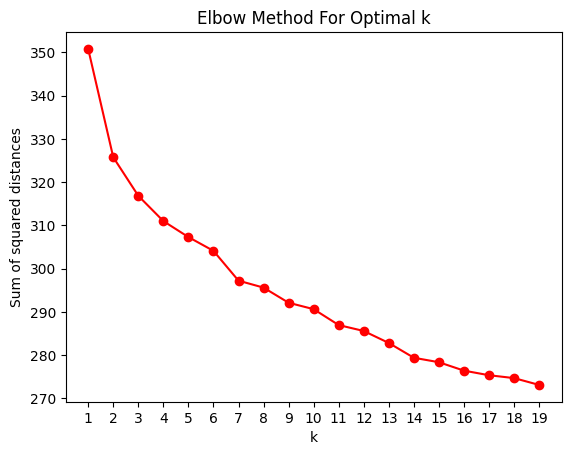

In [42]:
elbowMethod(embed10824, 20)


In [44]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embed10824)
Counter(clusters)

Counter({2: 203, 0: 169, 1: 28})

In [51]:
import plotly.io as pio

tsne = TSNE(n_components=2, random_state=42)  
tsne_results = tsne.fit_transform(embed10824)

df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
df['hashtag'] = suggwords10824
df['cluster'] = clusters # the cluster indices where each news hashtags belong
#df.head()

# Create the scatter plot
fig = px.scatter(df, x='tsne_1', y='tsne_2', text='hashtag', color="cluster", color_continuous_scale="BlueRed")

# Format what to show next to the markers
fig.update_traces(textposition='top center', 
                  mode='markers+text', 
                  textfont=dict(size=6))

fig.update_layout(title='Embeddings of TikTok News Hashtags', width=800, height=800)
fig.show()


Getting pyktok data from file videos-newsHashtags-10824_full.json
Cluster 0:
['revolution', 'engineer', 'prrrr', 'victorian', 'paparazzi', 'baby', 'shani', 'confessions', 'lawsuit', 'kids', 'travel', 'storytime', 'ring', 'tudor', 'inflation', 'jets', 'maydecember', 'victorian', 'highcourt', 'medieval', 'softwareengineer', 'phone', 'fgm', 'tragedy', 'missingsister', 'wap', 'missing', 'giants', 'barrel', 'trump', 'afcon', 'savage', 'fy', 'fy', 'mvp', 'baby', 'medieval', 'brice', 'socialite', 'streaming', 'deconstruction', 'cops', 'women', 'dancegodlloyd', 'travisalexandercase', 'fynnyvideo', 'couple', 'relatable', 'senator', 'lawyer', 'carribean', 'afcon', 'afcon', 'titans']
Cluster 1:
['broadbent', 'crimestories', 'crimestories', 'dad', 'capcut', 'crimestories', 'plymouthnews', 'crimestories', 'capcut', 'mom', 'judge', 'babygirl', 'judge', 'crimestories', 'jodiarias']
Cluster 2:
['fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fyp', 'fy

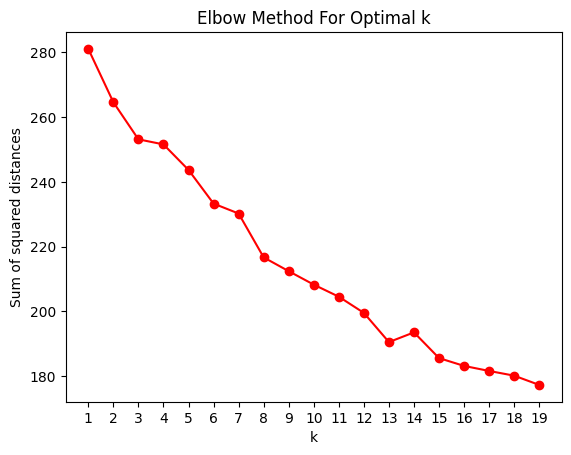

In [87]:
#filtered data
newswords10824 = sample(getsuggested_wordsfromjson('videos-newsHashtags-10824_full.json'),400)
newswords10824

embednews10824 = embed(newswords10824)

callKmeans(15,embednews10824,newswords10824)

elbowMethod(embednews10824, 20)


In [89]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clustersN = kmeans.fit_predict(embednews10824)
Counter(clusters)

Counter({2: 221, 0: 137, 1: 42})

In [90]:
tsneN = TSNE(n_components=2, random_state=42)  
tsne_resultsN = tsneN.fit_transform(embednews10824)

dfN = pd.DataFrame(tsne_resultsN, columns=['tsne_1', 'tsne_2'])
dfN['hashtag'] = newswords10824
dfN['cluster'] = clustersN # the cluster indices where each news hashtags belong
#df.head()

# Create the scatter plot
fig = px.scatter(dfN, x='tsne_1', y='tsne_2', text='hashtag', color="cluster", color_continuous_scale="BlueRed")

# Format what to show next to the markers
fig.update_traces(textposition='top center', 
                  mode='markers+text', 
                  textfont=dict(size=6))

fig.update_layout(title='Embeddings of TikTok News Hashtags', width=800, height=800)
fig.show()